In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(20, 16), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (7, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (4, 0))
        acf_ax_2 = plt.subplot2grid(layout, (3, 0))
        pacf_ax_2 = plt.subplot2grid(layout, (5, 0))        
        qq_ax = plt.subplot2grid(layout, (6, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        
        smt.graphics.plot_acf(y**2, lags=lags, ax=acf_ax_2, alpha=0.05)
        acf_ax_2.set_title('Autocorrelation in the squared residuals')
        smt.graphics.plot_pacf(y**2, lags=lags, ax=pacf_ax_2, alpha=0.05)
        pacf_ax_2.set_title('Partial Autocorrelation in the squared residuals')
        
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print(f'aic: {best_aic}  |  order: {best_order}')                    
    return best_aic, best_order, best_mdl

Рассмотрим временной ряд закрытия индекса Доу-Джонса и построим модели *ARIMA* и *GARCH*.

In [6]:
dow_jones = pd.read_csv('C:/Users/User/Desktop/Data Scientist/AML/Time_Series/Series/weekly-closings-of-the-dowjones-.csv')
series = dow_jones['Close']

In [7]:
# Продифференцируем ряд
series = series.values[2:] - 2 * series.values[1:-1] + series.values[:-2]

In [8]:
# Подберём параметры модели ARIMA по информационному критерию Акаике
aic, order, mdl = _get_best_model(series)

aic: 1416.2766998065404  |  order: (2, 0, 3)


Для авторегрессии оптимальным оказался второй порядок, для скользящего среднего - третий порядок, а второй параметр, отвечающий за тренд, оказался нулевым, т.к. мы продифференцировали ряд.  
Посмотрим на график остатков модели *ARIMA*, а также графики *ACF*, *PACF*, *QQ*.

Results of Dickey-Fuller Test:
Test Statistic                -1.184573e+01
p-value                        7.407482e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64


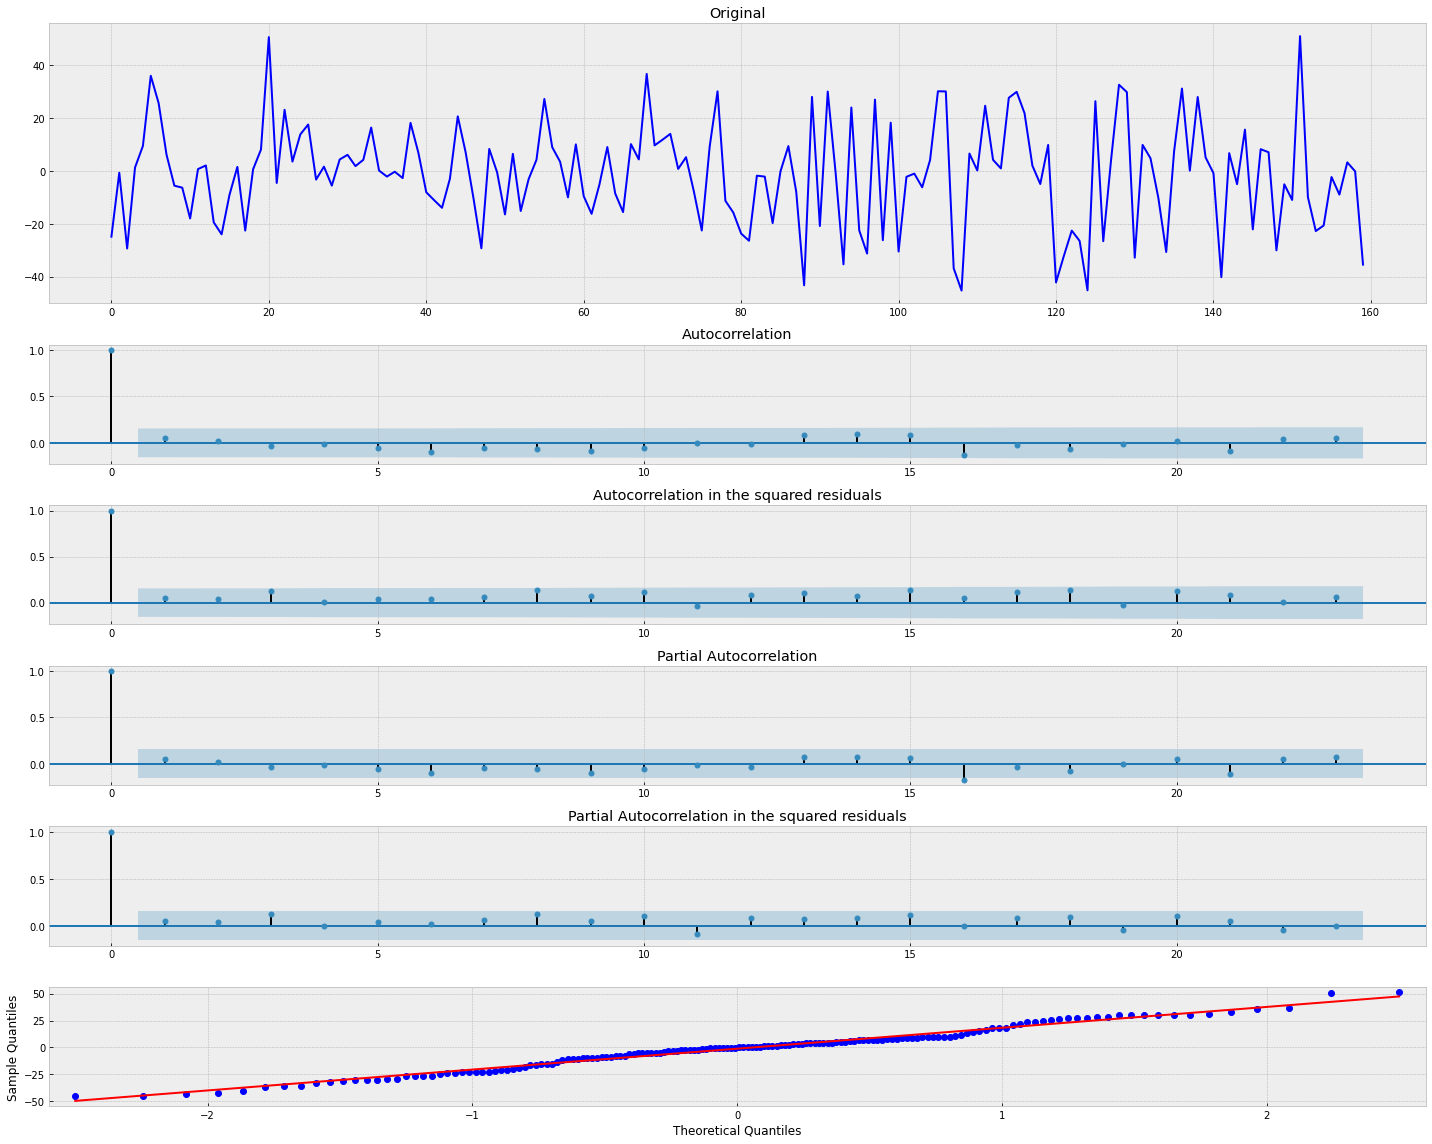

In [9]:
tsplot(mdl.resid)

Остатки модели похожи на белый шум. На графиках функций *ACF* и *PACF* по остаткам, а также по квадратам остатков не наблюдается значительной автокорреляции. На *нормальном графике КК* мы также видим, что точки не сильно отклоняются от базовой линии.  
Посмотрим на спрогнозированные значения.

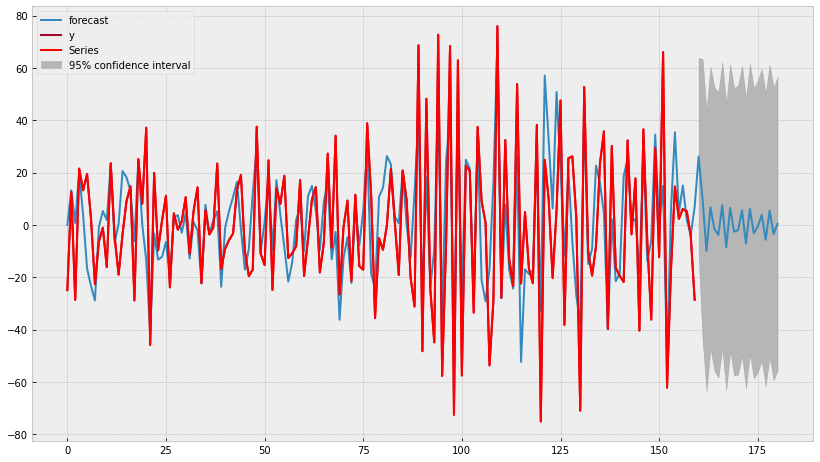

In [10]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    mdl.plot_predict(0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

На графиках дисперсия исходного ряда больше, чем у его модели *ARIMA*. Также последние значения ряда сильно отличаются от прогнозируемых.  
Построим модель *GARCH* на подобранных по модели *ARIMA* параметрах $\alpha$, $\beta$, $\gamma$ и посмотрим на графики.

In [11]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     52,   Neg. LLF: 747.7804538970734
Iteration:     10,   Func. Count:    102,   Neg. LLF: 746.7912394464223
Iteration:     15,   Func. Count:    152,   Neg. LLF: 746.2796559437129
Iteration:     20,   Func. Count:    202,   Neg. LLF: 746.2520912042494
Iteration:     25,   Func. Count:    254,   Neg. LLF: 746.2474387295399
Iteration:     30,   Func. Count:    304,   Neg. LLF: 746.1750949227243
Iteration:     35,   Func. Count:    358,   Neg. LLF: 746.1248167043511
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 746.1201114254919
            Iterations: 39
            Function evaluations: 411
            Gradient evaluations: 39
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                    

Results of Dickey-Fuller Test:
Test Statistic                  -5.043437
p-value                          0.000018
#Lags Used                      14.000000
Number of Observations Used    145.000000
Critical Value (1%)             -3.476273
Critical Value (5%)             -2.881688
Critical Value (10%)            -2.577513
dtype: float64


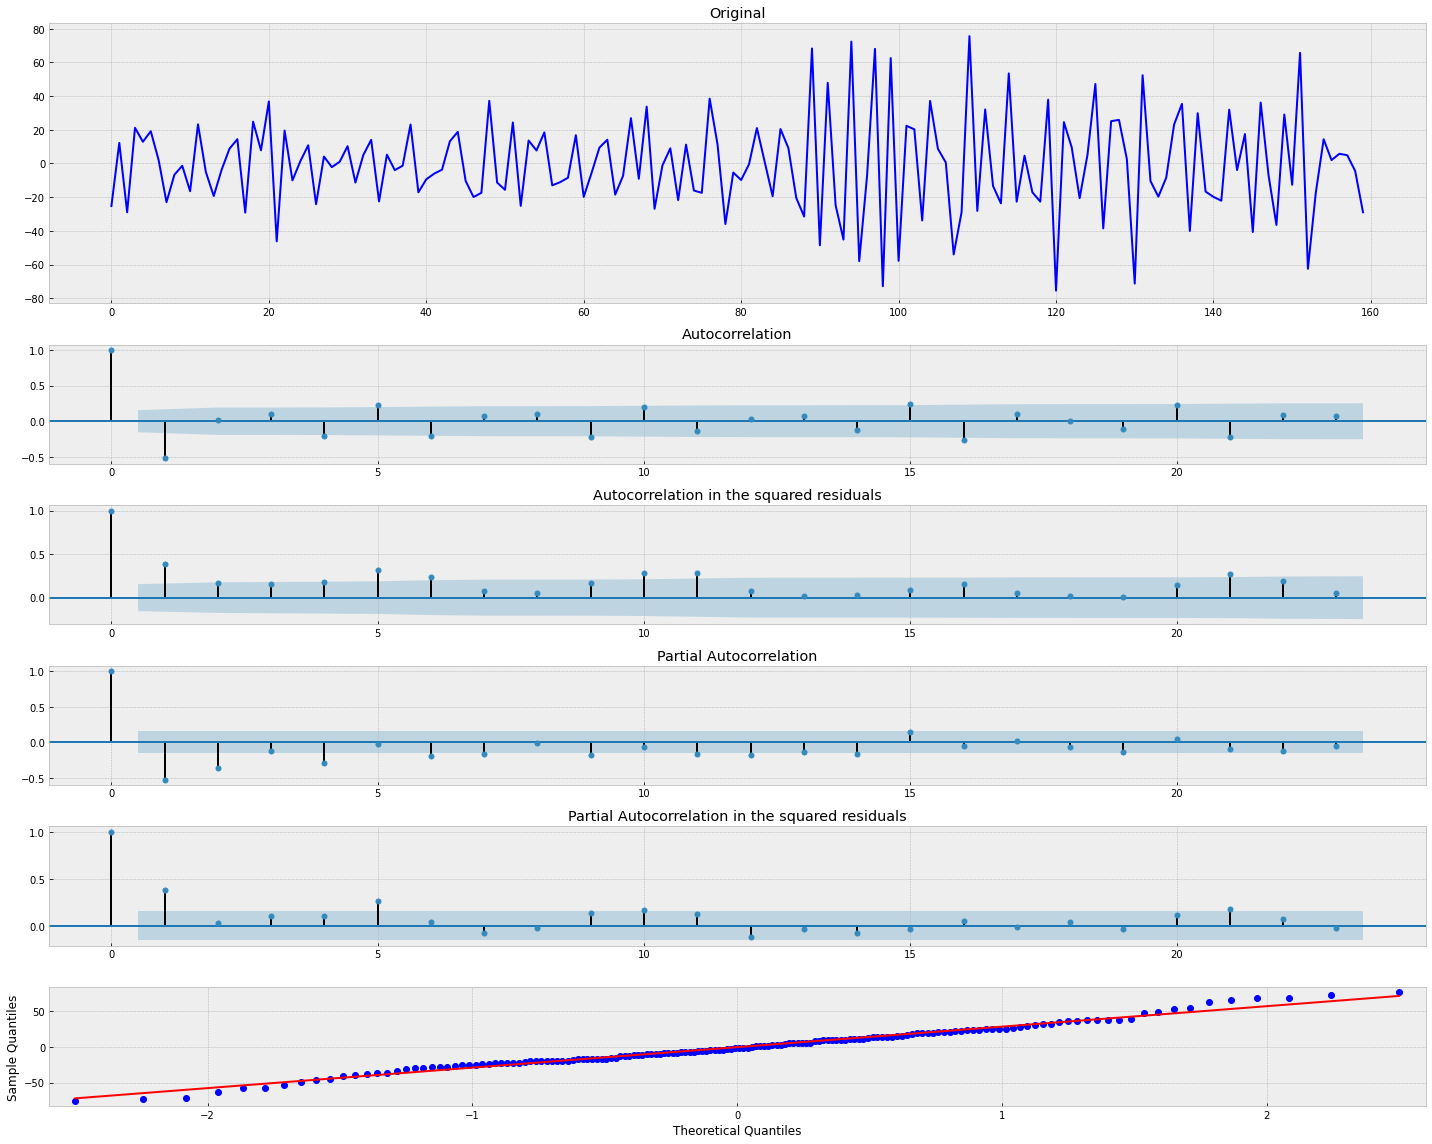

In [12]:
tsplot(res.resid)

На графиках функций *ACF* и *PACF* есть автокорреляция, график остатков также не похож на белый шум. Следовательно, модель *ARIMA* лучше описывает наш ряд.

---

Попробуем спрогнозировать ряд моделями *линейной регрессии* и *случайного леса*.

In [13]:
series = dow_jones['Close']

In [14]:
def prepareData(ser, lag_start=1, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(ser)
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(ser)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = ser.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].iloc[:, 1:]
    y_train = data.loc[:test_index].iloc[:, :1]
    X_test = data.loc[test_index:].iloc[:, 1:]
    y_test = data.loc[test_index:].iloc[:, :1]
    
    return X_train, X_test, y_train, y_test

In [15]:
# Разделим ряд на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

In [16]:
# Обучим модели
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

reg_rf = RandomForestRegressor(random_state=1)
reg_rf.fit(X_train, y_train)
rf_prediction = reg_rf.predict(X_test)

Сравним предсказания моделей *линейной регрессии* и *случайного леса* с тестовыми данными.

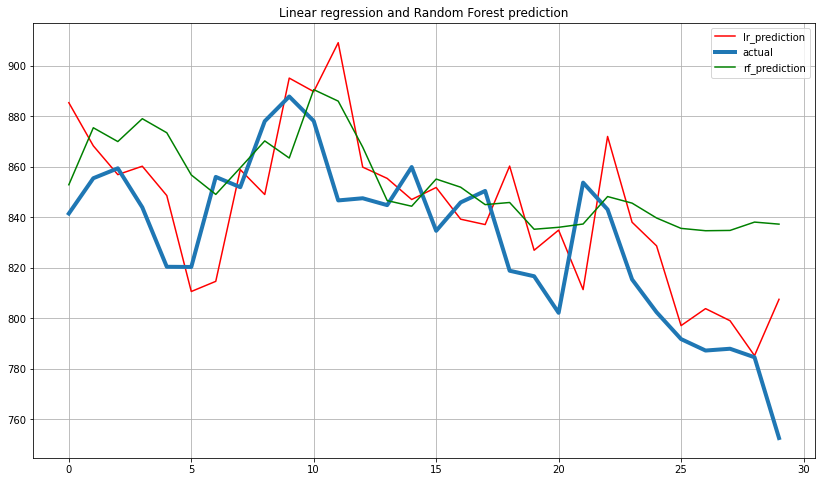

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="lr_prediction")
plt.plot(y_test.values, linewidth='4', label="actual")
plt.plot(rf_prediction, "g", label="rf_prediction")

plt.legend(loc="best")
plt.title("Linear regression and Random Forest prediction")
plt.grid(True);

Очевидно, что модель *линейной регресси* лучше описывает ряд, особенно в конце. Но на последнем значении мы снова видим большое отличие (как и в случае с моделью *ARIMA*). Этот резкий спад скорее всего связан с политическим событием, произошедшим в тот момент времени (отставка 37-го президента США Ричарда Никсона), и, к сожалению, наша модель это предсказать не способна.  
Предскажем 10 значений нашего ряда с помощью *линейной регрессии*.

In [18]:
def forecasting(ser, alg, n_forecast=10, start_lag=1, end_lag=20, size_test=0.3):
    """
    Not adapted for: start_lag > 1
    Depending on series and test size: log_end < len(Series) - 100
    """
    forecast = []
    X_train, X_test, y_train, y_test = prepareData(ser, lag_start=start_lag, lag_end=end_lag, test_size=size_test)
    alg.fit(X_train, y_train)
    alg_pred = alg.predict(X_test)
    
    ser_ = series[-(end_lag-1):].values
    
    for i in range(n_forecast):
        pred_ = alg.predict([ser_[i:][::-1]])
        forecast = np.append(forecast, pred_)
        ser_ = np.append(ser_, pred_)
    
    return forecast

In [19]:
forecast_ = np.empty_like(series)
forecast_[:] = np.nan
forecast_ = np.append(forecast_, forecasting(series, lr))

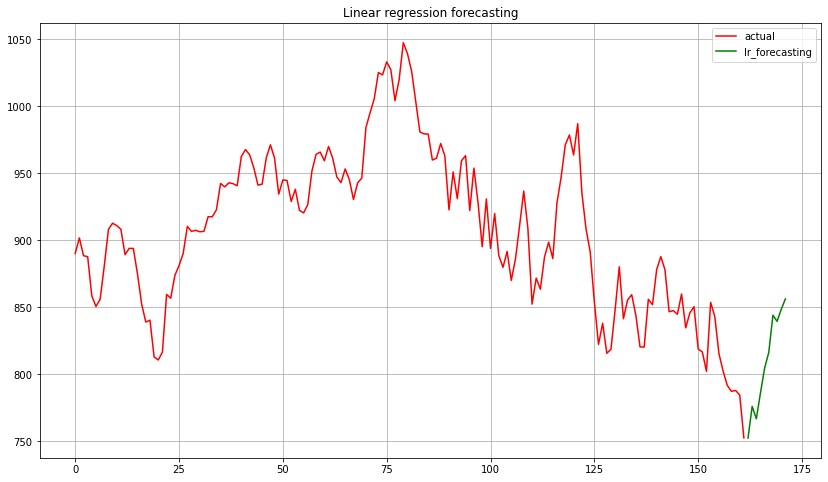

In [20]:
plt.figure(figsize=(14, 8))
plt.plot(series, 'r', label='actual')
plt.plot(forecast_, 'g', label='lr_forecasting')
plt.legend(loc="best")
plt.title("Linear regression forecasting")
plt.grid(True);